In [1]:
!pip install -q monai

In [2]:
from PIL import Image
import torch
from glob import glob
from datasets import Dataset as DS
import albumentations as A
import torchvision.transforms as T
from torch.utils.data import Dataset

from PIL import Image
import numpy as np
height, width = (256, 256)

torch.cuda.is_available

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<function torch.cuda.is_available() -> bool>

In [3]:
X = sorted(glob(
    '/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/*'
))

Y = sorted(glob(
    '/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Masks/*'
))

In [4]:
len(X)

2841

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state= 42)

In [6]:
len(X_train)

2272

In [7]:
class LoadData(Dataset):
    def __init__(self, images_path, masks_path):
        super().__init__()

        self.images_path = images_path
        self.masks_path = masks_path
        self.len = len(images_path)
        self.transform = A.Compose([
            A.Resize(height,width)
            #A.HorizontalFlip(),
            #A.RandomBrightnessContrast(p=0.5),
            #A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        ])
        

    def __getitem__(self, idx):
        img = Image.open(self.images_path[idx])
        mask = Image.open(self.masks_path[idx]).convert('L')
        
        img,mask=np.array(img),np.array(mask)
        transformed = self.transform(image=img, mask=mask)
        img = transformed['image']
        mask = transformed['mask']

        img = np.transpose(img, (2, 0, 1))
        img = img/255.0
        img = torch.tensor(img)

        mask = np.expand_dims(mask, axis=0)
        mask = mask/255.0
        mask = torch.tensor(mask)

        return {"image":img, "mask": mask}
    
    def __len__(self):
        return self.len

In [8]:
train_dataset = LoadData(images_path=X_train, masks_path=y_train)
valid_dataset = LoadData(X_val, y_val)

In [9]:
type(train_dataset), len(train_dataset)

(__main__.LoadData, 2272)

In [10]:
T.ToPILImage(train_dataset[2]["mask"])

ToPILImage(mode=tensor([[[0.9961, 0.9961, 0.0118,  ..., 0.9608, 0.9608, 1.0000],
         [0.9961, 0.9961, 0.0118,  ..., 0.9608, 0.9608, 1.0000],
         [0.9961, 0.9961, 0.0118,  ..., 0.0549, 0.0549, 0.9412],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.9843, 0.9843, 1.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.9843, 0.9843, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.9843, 0.9843, 1.0000]]],
       dtype=torch.float64))

In [11]:
(len(train_dataset[2]["image"]), len(train_dataset[2]["mask"])), len(X_train), type(train_dataset[2]["image"])

((3, 1), 2272, torch.Tensor)

In [12]:
images =  []
masks = []

In [13]:
for i in range(len(X_train)):
    images.extend([train_dataset[i]["image"]])
    masks.extend([train_dataset[i]["mask"]])

In [14]:
len(images), len(masks), type(images[4])

(2272, 2272, torch.Tensor)

In [15]:
dataset_dict = {
    "image": [T.ToPILImage()(img) for img in images],
    "label": [T.ToPILImage()(mask) for mask in masks]
}

In [16]:
dataset = DS.from_dict(dataset_dict)

In [17]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 2272
})

In [18]:
import matplotlib.pyplot as plt


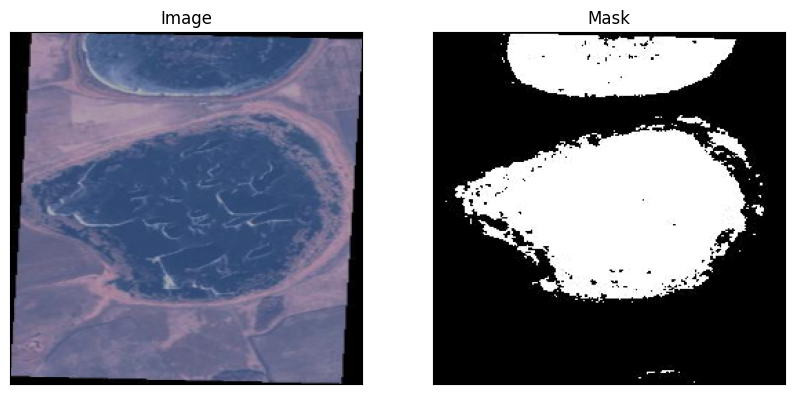

In [19]:
example_image = dataset[2000]["image"]
example_mask = dataset[2000]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [20]:
# Getting bounding boxes from mask
def get_bounding_box(ground_truth_mask):
    # get bbox from mask
    y_indices, x_indices = np.where(ground_truth_mask > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bbox coordinates
    #print(ground_truth_mask.shape[::-1])
    H, W = ground_truth_mask.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]

    return bbox

In [21]:
class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [22]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [23]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [24]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


# Creating PyTorch DataLoader

In [25]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [26]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [27]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

# Load & Train the model

In [28]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)


In [29]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.GeneralizedDiceFocalLoss(sigmoid= False, reduction="mean")

In [30]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

num_epochs = 4

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

100%|██████████| 1136/1136 [18:36<00:00,  1.02it/s]


EPOCH: 0
Mean loss: 0.4208729174455405


100%|██████████| 1136/1136 [18:37<00:00,  1.02it/s]


EPOCH: 1
Mean loss: 0.19645899270897285


100%|██████████| 1136/1136 [18:35<00:00,  1.02it/s]


EPOCH: 2
Mean loss: 0.16358238603875883


100%|██████████| 1136/1136 [18:33<00:00,  1.02it/s]

EPOCH: 3
Mean loss: 0.1500382376161468


In [31]:
# Saving model
# torch.save(ckpt, 'ckpts.pth')
torch.save(model.state_dict(), "model_ckpt2.pth")

# Inference

In [ ]:
# if you did save the model run this cell to load your existing model.
"""
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
myModel = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
myModel.load_state_dict(torch.load("/kaggle/working/model_ckpt2.pth"))

# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
myModel.to(device)
"""

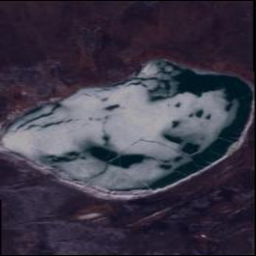

In [36]:
dataset[120]["image"]#, np.array(dataset[16]["label"])

In [38]:
image=  dataset[120]["image"]
# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[120]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
for k,v in inputs.items():
  print(k,v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])


In [39]:
model.eval()

# forward pass
with torch.no_grad():
  outputs = model(**inputs, multimask_output=False)

In [40]:
# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

(-0.5, 255.5, 255.5, -0.5)

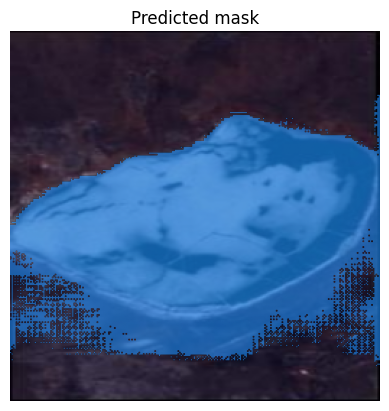

In [41]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(medsam_seg, axes)
axes.title.set_text(f"Predicted mask")
axes.axis("off")

(-0.5, 255.5, 255.5, -0.5)

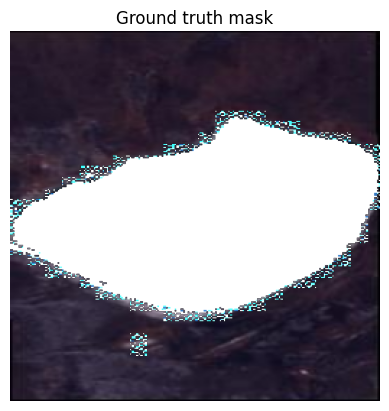

In [42]:
fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(ground_truth_mask, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

#### note


The finetuning process definitely can be better than this. Biggest reason that explains why I could not get better results 
were time & also cost. Since I wrote this code for learning purposes mostly, achieved its goal.